## Text Classification with spaCy and sklearn

Import needed modules

In [1]:
import os
import pickle

# visualization
import matplotlib.pyplot as plt

# pandas
import pandas as pd

# sklearnlinter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# nlp
import spacy
import textacy

Set the project path to your local folder.

In [2]:
# set path to project -> change if needed
project_path = '/Users/EB/Google Drive/Projects/breweries'

Configure matplotlib: use a cleaner template.

In [3]:
# configure matplotlib
plt.style.use('seaborn-white')

Define functions.

In [4]:
def spacy_pipe(nlp):
    """Custom spacy pipeline."""
    return(nlp.tagger, nlp.parser)


def get_lem(doc):
    """Return lemma of spacy doc if lemma is noun / adjective."""
    interesting_pos = ('NOUN', 'PROPN', 'ADJ')
    lems = [word.lemma_ for word in doc if word.pos_ in interesting_pos]

    return lems


def get_chunk(noun_chunk):
    """Return interesting parts of noun chunks."""
    interesting_pos = ('NOUN', 'PROPN', 'ADJ', 'ADV', 'VERB')
    chunk = [tok.lemma_ for tok in noun_chunk if tok.pos_ in interesting_pos]

    if len(chunk) > 1:
        return ' '.join(chunk)
    else:
        return ''


def term_list(doc):
    """Return term list item which is used to create term document matrix."""
    tl = []

    # lemmata of nouns and adjectives
    tl.extend(get_lem(doc))

    # noun chunks
    chunks = [get_chunk(chunk) for chunk in doc.noun_chunks]
    chunks = [chunk for chunk in chunks if chunk]
    tl.extend(chunks)

    return tl


def get_top_topic(model, doc_topic_matrix):
    """Return top topic of estimated topic model."""
    top_topics = model.top_doc_topics(doc_topic_matrix, top_n=1)
    top_topics = [topics[0] for doc_idx, topics in top_topics]
    return top_topics


def accuracy(pred, actual):
    """Calculate accuracy of predictions."""
    return sum(pred == actual) / len(pred)


Load pickled data.

In [5]:
os.chdir(project_path + '/data/')
data = pickle.load(open('2styles_sample.p', 'rb'))

Load spacy pipeline for English and parse reviews.

In [6]:
# Load spacy pipeline for English
nlp = spacy.load('en', create_pipeline=spacy_pipe)

# parse via pipeline
texts = [doc for doc in nlp.pipe(data[1], n_threads=-1)]

Create term list and document term matrix.

In [7]:
# create term list
tl = [term_list(doc) for doc in texts]

# document term matrix
dtm_specs = {'terms_lists': (tl),
             'weighting': 'tfidf',
             'normalize': 'True',
             'smooth_idf': 'True',
             'min_df': 5,
             'max_df': 0.95}

dtm, id2t = textacy.vsm.doc_term_matrix(**dtm_specs)

### Topic Modeling

We use Latent Dirichlet allocation (LDA) as model to group our texts into 5 different topics.

In [8]:
model = textacy.tm.TopicModel('lda', n_topics=5)
model.fit(dtm)

We can now read out the top 6 terms for each topic.

In [9]:
for topic_idx, top_terms in model.top_topic_terms(id2t, top_n=6):
    print('Topic', topic_idx, ':', ', '.join(top_terms))

Topic 0 : chocolate, coffee, porter, dark, roasted, black
Topic 1 : beer, my, good, pumpkin, what, its
Topic 2 : lager, light, hop, white, pale, malt
Topic 3 : hop, medium, malt, light, finish, moderate
Topic 4 : vanilla, cream, bourbon, syrup, bean, beer


We can now assign these topics back to our document term matrix and check how the topic relates to the beer style.

In [10]:
doc_topic_matrix = model.transform(dtm)

In [11]:
df = pd.DataFrame(doc_topic_matrix)
df['style_name'] = [i['style_name'] for i in data[0]]
df['top_topic'] = get_top_topic(model, doc_topic_matrix)

In [12]:
print(pd.crosstab(df['style_name'], df['top_topic']))

top_topic               0     1     2     3    4
style_name                                      
American Pale Lager    68  1272  4706   643  161
American Porter      7612   981   201  1649  732


Topics 1 and 2 mostly relate to American Pale Lager while topics 0, 3 and 4 seem to relate to American Porter.
However, we can also visualize the frequency in percentages.

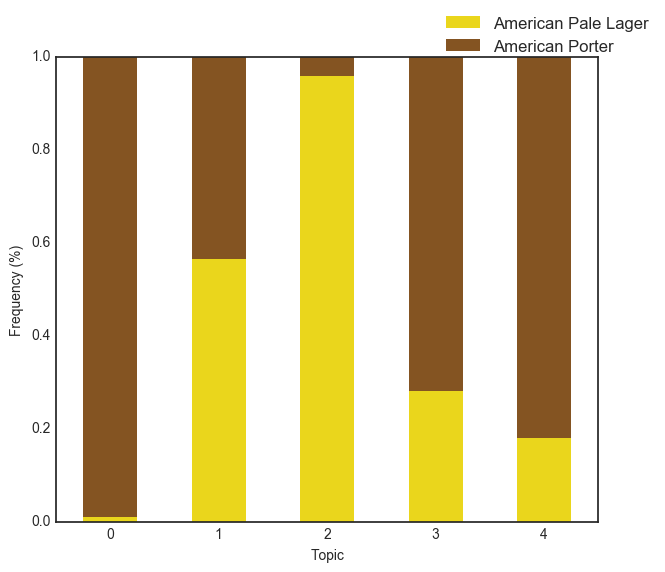

In [13]:
ct = pd.crosstab(df['top_topic'], df['style_name'])
ct = ct.apply(lambda r: r / r.sum(), axis=1)

beer_plot = ct.plot.bar(stacked=True, color=['#ead61c', '#845422'],
                        edgecolor='none', lw=2, rot=0, figsize=(7, 6))
beer_plot.set_xlabel('Topic')
beer_plot.set_ylabel('Frequency (%)')
beer_plot.legend(bbox_to_anchor=(1.12, 1.12))

plt.show()

### Support Vector Machines

We can either use the document topic matrix or the document term matrix as explaining variables in the SVM model 

#### Option A: 
- X = document topic matrix
- We have less variables as input and the estimation will be faster, which is nice as we have to tune many hyperparameters.

In [14]:
X = pd.DataFrame(doc_topic_matrix)

# numeric encoding for y variable (beer style)
bin_encode = {'American Pale Lager': 0,
              'American Porter': 1}
y = df['style_name'].map(bin_encode)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [16]:
seed = 123
folds = 5

In [17]:
# hyperparameters -> usually more tunings, just for illustration
parameters = {'clf__kernel': ('rbf', 'poly', 'linear', 'sigmoid'),
              'clf__gamma': ('auto', 1),
              'clf__C': (10, 1.0, 0.1)}

In [18]:
piper = Pipeline([('clf', SVC(random_state=seed))])

grid_search = GridSearchCV(piper, parameters, n_jobs=3, verbose=1,
                           refit=True, cv=folds)

grid_search.fit(X_train, y_train)

print('Best score: %0.3f' % grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   23.6s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  1.4min finished


Best score: 0.968


In [19]:
print(grid_search.best_estimator_)

Pipeline(steps=[('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False))])


In [20]:
y_pred = grid_search.predict(X_test)

res = pd.DataFrame({'y_test': pd.Series(y_test)})
res['y_pred'] = y_pred

print(pd.crosstab(res['y_test'], res['y_pred'], rownames=['True'],
                  colnames=['Predicted']))

print('Accuracy in test set: %0.3f' % accuracy(res['y_pred'], res['y_test']))

Predicted    0     1
True                
0          663    33
1           27  1080
Accuracy in test set: 0.967


#### Option B: 
- X = document term matrix
- We have more variables as input and the estimation will be slower for the same number of hyperparameter options

In [21]:
X = dtm

# split in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=123)

In [22]:
parameters = {'clf__kernel': ('rbf', 'linear')}

piper = Pipeline([('clf', SVC(C=1.0, gamma='auto', random_state=seed))])

grid_search = GridSearchCV(piper, parameters, n_jobs=3, verbose=1,
                           refit=True, cv=folds)

grid_search.fit(X_train, y_train)

print('Best score: %0.3f' % grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.4min finished


Best score: 0.994


In [23]:
print(grid_search.best_estimator_)

Pipeline(steps=[('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False))])


In [24]:
y_pred = grid_search.predict(X_test)
res = pd.DataFrame({'y_test': pd.Series(y_test)})
res['y_pred'] = y_pred

In [25]:
print(pd.crosstab(res['y_test'], res['y_pred'], rownames=['True'],
                  colnames=['Predicted']))

Predicted    0     1
True                
0          693     3
1           11  1096


In [26]:
print('Accuracy in test set: %0.3f' % accuracy(res['y_pred'], res['y_test']))

Accuracy in test set: 0.992
